In [6]:
import torch
import torch.nn as nn

import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [7]:
from model import QNetwork, get_network_input
from Game import GameEnvironment
from collections import deque
from replay_buffer import ReplayMemory
import time

model = QNetwork(10, 20, 5)
epsilon = 0.1
grid_size = 15 
GAMMA = 0.9

board = GameEnvironment(grid_size, nothing=0, dead=-1, apple=1)
memory = ReplayMemory(1000)  
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [8]:
import numpy as np
def run_episode(num_games, model, memory:ReplayMemory, epsilon, board:GameEnvironment):
    run = True
    games_played = 0
    total_reward = 0    
    episode_games = 0
    snake_len_array = []
    
    while run:
        # TODO: Get state
        state = get_network_input(board.snake, board.apple)
        action_0=model(state)
        
        # TODO: Compare a random number with epsilon and find out the next action
        rand=np.random.uniform(0,1)
        #epsilon greedy
        if rand > epsilon:
            next_action=torch.argmax(action_0)
        else:
            next_action=np.random.randint(0, 5)

        reward, done, len_of_snake = board.update_board_state(next_action)

        # TODO: Get next state
        next_state = get_network_input(board.snake, board.apple)

        memory.push(state, next_action, reward, next_state, done)
        
        # TODO: update total reward
        total_reward += reward
        
        episode_games += 1
        
        if board.game_over:
            games_played += 1
            snake_len_array.append(len_of_snake)
            board.reset_game()
            
            if num_games == games_played:
                run = False
                
    avg_len_of_snake = np.mean(snake_len_array)
    max_len_of_snake = np.max(snake_len_array)
    return total_reward, avg_len_of_snake, max_len_of_snake



In [9]:
MSE = nn.MSELoss()
def learn(num_updates, batch_size, model, target_model, memory, optimizer, gamma):
    
    total_loss = 0
    
    for i in range(num_updates):

        optimizer.zero_grad()
        sample = memory.sample(batch_size)
            
        states, actions, rewards, next_states, dones = sample
        states = torch.cat([x.unsqueeze(0) for x in states], dim=0)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.cat([x.unsqueeze(0) for x in next_states], dim=0)
        dones = torch.FloatTensor(dones)
        
        # TODO: Get Q values for current state
        q_local = model(states)
        
        # TODO: Get Q values for next state
        next_q_value = target_model(next_states).detach()

        Q_expected = q_local.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        Q_targets_next = next_q_value.max(1)[0] * (1 - dones)
        
        # TODO: Calculate Q targets for current state
        Q_targets = rewards + (gamma * Q_targets_next)

        loss = MSE(Q_expected, Q_targets)
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    return total_loss

In [10]:
num_episodes = 3000 
num_updates = 200 
print_every = 100
games_in_episode = 30
batch_size = 20


def train():
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    avg_len_array = []
    avg_max_len_array = []
    
    time_start = time.time()
    
    
    for i_episode in range(num_episodes+1):
        
         # TODO: Run an episode
        score, avg_len, max_len = run_episode(games_in_episode, model, memory, epsilon, board)
        
        scores_deque.append(score)
        scores_array.append(score)
        avg_len_array.append(avg_len)
        avg_max_len_array.append(max_len)
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        # TODO: Learn from the episode
        total_loss = learn(num_updates, batch_size, model, model, memory, optimizer, GAMMA)
        
        dt = (int)(time.time() - time_start)
        
        if i_episode % print_every == 0 and i_episode > 0:
            print('Ep.: {:6}, Loss: {:.3f}, Avg.Score: {:.2f}, Avg.LenOfSnake: {:.2f}, Max.LenOfSnake:  {:.2f} Time: {:02}:{:02}:{:02} '.\
                  format(i_episode, total_loss, score, avg_len, max_len, dt//3600, dt%3600//60, dt%60))
            
        memory.truncate()
        
        if i_episode % 250 == 0 and i_episode > 0:   
            torch.save(model.state_dict(), './model/Snake_{}'.format(i_episode))
            
    return scores_array, avg_scores_array, avg_len_array, avg_max_len_array    

# TODO: Train the model
scores, avg_scores, avg_len_of_snake, max_len_of_snake = train()

Ep.:    100, Loss: 5.495, Avg.Score: -27.00, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:01:05 
Ep.:    200, Loss: 3.873, Avg.Score: -26.00, Avg.LenOfSnake: 5.13, Max.LenOfSnake:  7.00 Time: 00:02:20 
Ep.:    300, Loss: 3.078, Avg.Score: -25.00, Avg.LenOfSnake: 5.17, Max.LenOfSnake:  6.00 Time: 00:04:03 
Ep.:    400, Loss: 2.974, Avg.Score: -23.00, Avg.LenOfSnake: 5.23, Max.LenOfSnake:  7.00 Time: 00:05:50 
Ep.:    500, Loss: 2.902, Avg.Score: -28.00, Avg.LenOfSnake: 5.07, Max.LenOfSnake:  6.00 Time: 00:07:39 
Ep.:    600, Loss: 3.262, Avg.Score: -23.00, Avg.LenOfSnake: 5.23, Max.LenOfSnake:  7.00 Time: 00:09:30 
Ep.:    700, Loss: 3.087, Avg.Score: -25.00, Avg.LenOfSnake: 5.17, Max.LenOfSnake:  6.00 Time: 00:11:22 
Ep.:    800, Loss: 2.925, Avg.Score: -20.00, Avg.LenOfSnake: 5.30, Max.LenOfSnake:  7.00 Time: 00:13:16 
Ep.:    900, Loss: 3.327, Avg.Score: -19.00, Avg.LenOfSnake: 5.37, Max.LenOfSnake:  7.00 Time: 00:15:08 
Ep.:   1000, Loss: 3.956, Avg.Score: -17.00, Avg.LenOfS

length of scores:  3001 , len of avg_scores:  3001


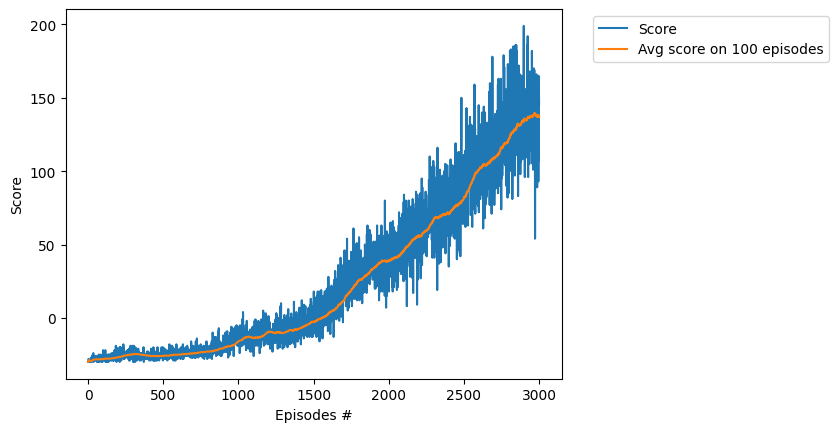

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg score on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

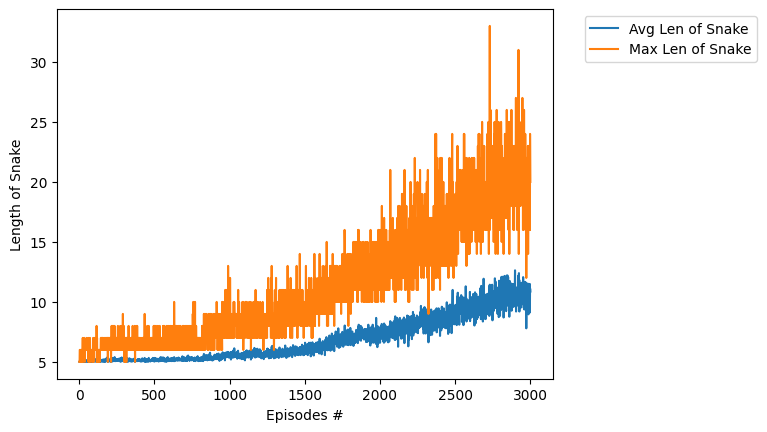

In [12]:
ax1 = fig.add_subplot(121)
plt.plot(np.arange(1, len(avg_len_of_snake)+1), avg_len_of_snake, label="Avg Len of Snake")
plt.plot(np.arange(1, len(max_len_of_snake)+1), max_len_of_snake, label="Max Len of Snake")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Length of Snake')
plt.xlabel('Episodes #')
plt.show()